In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

import keras
from keras import layers
import rasterio

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night VIIRS_1.tif"
#pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=1, area=aoi)

trainMask = dataRadiance>25
lightCoords = dataCoords[trainMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])


Tiles: 552389
Light Tile: 3610


In [3]:
# Fetch images
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.getEachImgFromCoord(f, dataCoords[trainMask], True)
trainData = utils.formatData(trainData, res=32, toFloat=True)
print(trainData.shape)

(3610, 32, 32, 3)


# Autoencoder

In [4]:
# Input encoder
input_shape = trainData.shape[1:]

#optimizer = 'adam'
optimizer = keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)

#lossFunction = keras.losses.MeanAbsoluteError() # L1
lossFunction = keras.losses.MeanSquaredError() # l2
#lossFunction = tf.keras.losses.KLDivergence()

activationFunction = lambda x: tf.keras.activations.relu(x, max_value=255)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3)

autoencoder = keras.Sequential([
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu', input_shape=input_shape),
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu'),

  layers.Flatten(name='encoder'),
  layers.Reshape(target_shape=(4,4,16)),

  #layers.UpSampling2D((2,2)),
  layers.Conv2DTranspose(16,(3,3), 2, padding='same', activation='relu'),
  #layers.UpSampling2D((2,2)),
  layers.Conv2DTranspose(16,(3,3), 2, padding='same', activation='relu'),
  #layers.UpSampling2D((2,2)),

  layers.Conv2DTranspose(3, (3,3), 2, padding='same', activation='sigmoid', name='decoder'),
])

autoencoder.compile(optimizer=optimizer, loss=lossFunction)

print('Encoder shape:',autoencoder.get_layer('encoder').output_shape)

autoencoder.get_output_shape_at

result = autoencoder.fit(trainData, trainData,
                          epochs=50,
                          batch_size=2,
                          shuffle=True,
                          verbose=0,
                          callbacks=[
                            TqdmCallback(verbose=1), # Concise display progression
                            earlyStop,
                          ],
                        )


Encoder shape: (None, 256)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 16)          2320      
                                                                 
 encoder (Flatten)           (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 16)         2320      
 nspose)                                                         
                                                        

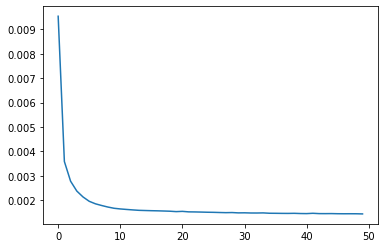

In [5]:
matPlt.plot(result.history['loss'][:], label='Training')
#matPlt.plot(result.history['val_loss'], label='Testing')
autoencoder.summary()

Test display some tiles
Original data: (40, 32, 32, 3)


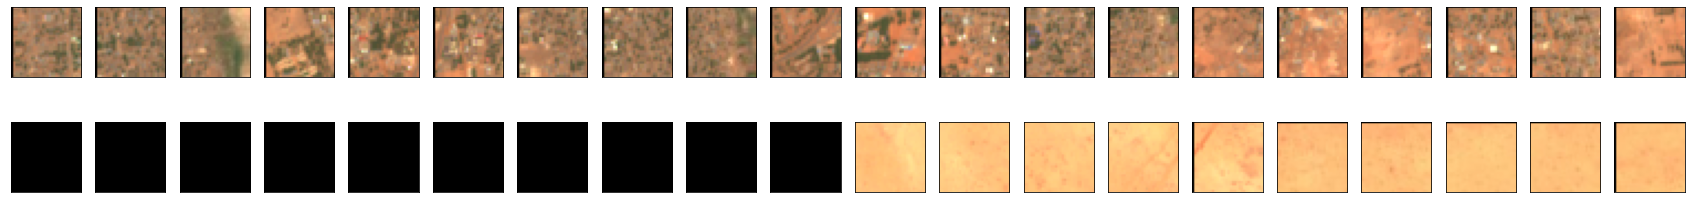

2/2 [==============================] - 0s 3ms/step
Output data: (40, 32, 32, 3)


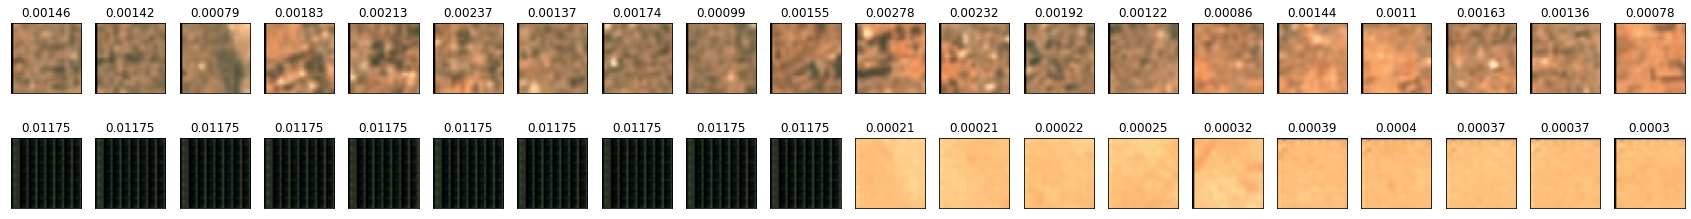

In [7]:
print("Test display some tiles")

indexesTest = [*np.argwhere(trainMask)[-20:].flatten(), *range(0,1), *range(1104,1108), *range(1118,1123), *range(4005,4010), *range(10005,10010)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.getEachImgFromCoord(f, dataCoords[indexesTest], True)
dataTest = utils.formatData(dataTest, res=32, toFloat=True)

utils.displayAutoEncoderResults(autoencoder, dataTest, showDetail=0, precision=5)

In [8]:
autoencoder.save('model/autoencoder_32x32_encoder_256')

INFO:tensorflow:Assets written to: model/autoencoder_32x32_encoder_256\assets


INFO:tensorflow:Assets written to: model/autoencoder_32x32_encoder_256\assets
